In [ ]:
import warnings

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import cmaps
import cftime
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nc_time_axis
import numpy as np
from scipy import stats
from shapely import geometry
import xarray as xr 

from src import cesm_utils, models, plots, utils
from src.inputs import * 

%load_ext autoreload
%autoreload 2
%matplotlib inline 

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# List of CESM2 Ensemble Members
ensemble_members = models.CESM2_ensemble_members

In [3]:
# Calculate 13-year running correlation between ENSO and MSEA in CESM2
# ENSO: DJF SSTs in Niño3.4 region
# MSEA: MAM prect in MSEA region

# note: cell should take <4s to run
cesm_correlations_list, cesm_msea_prect_anomaly_timeseries_mam_list, cesm_nino34_sst_anomaly_timeseries_djf_list = (
    cesm_utils.calculate_cesm_ensemble_runcorr(
        ensemble_members, 
        CESM2_LENS2_dir, 
        window=13))

cesm_correlations_da = xr.concat(cesm_correlations_list, dim='ensemble')

In [4]:
# Concatenate ENSO and MSEA lists into xr.DataArray
# and select historical (1900-2014) period

cesm_msea_prect_anomaly_timeseries_mam_da = xr.concat(
    cesm_msea_prect_anomaly_timeseries_mam_list, dim='ensemble')
cesm_nino34_sst_anomaly_timeseries_djf_da = xr.concat(
    cesm_nino34_sst_anomaly_timeseries_djf_list, dim='ensemble')

cesm_msea_prect_anomaly_timeseries_mam_da_1900_2014 = (
    cesm_msea_prect_anomaly_timeseries_mam_da.sel(time=slice('1900','2014')))
cesm_nino34_sst_anomaly_timeseries_djf_da_1900_2014 = (
    cesm_nino34_sst_anomaly_timeseries_djf_da.sel(time=slice('1900','2014')))

In [5]:
# Randomly select 10,000 13-year timeseries between 1900-2014
# For each 13-year period, calculate correlation and store ensemble member idx and start-year 

# note: cell should take ~1m to run
random_13yr_periods_df = utils.select_random_timeseries(
    sst_data=cesm_nino34_sst_anomaly_timeseries_djf_da_1900_2014, 
    prect_data=cesm_msea_prect_anomaly_timeseries_mam_da_1900_2014,
    num_samples=10000
    )

In [6]:
# Select upper quartile, lower quartile, and random quartile of correlations
upper_df, lower_df, random_df_len_upper, random_df_len_lower = (
    utils.select_correlation_quartiles(random_13yr_periods_df, sort_by="Correlations")
)

In [7]:
# For each ensemble member, get timeseries of global SST maps (see data_processing.ipynb)
cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(
    ensemble_members, 
    CESM2_LENS2_dir,
    "SST.global.1900_2100")  # annual global DJF ssts
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1900', '2015'))

In [8]:
# Select corresponding upper quartile, lower quartile, and random quartile of global SSTs
upper_sst_da, lower_sst_da, random_len_upper_sst_da, random_len_lower_sst_da = utils.select_field_quartiles(
    cesm_global_djf_sst_map, 
    dataframe_categories=[upper_df, lower_df, random_df_len_upper, random_df_len_lower]
    )

In [9]:
# Take difference of upper/lower quartile SSTs relative to random, calculate ttest

# Upper Quartile SSTs
print(len(upper_sst_da.random))
upper_sst_difference_da = upper_sst_da.mean(dim='random') - random_len_upper_sst_da.mean(dim='random')
_, upper_pvals = stats.ttest_ind(upper_sst_da, random_len_upper_sst_da, equal_var=False)
upper_pvals = utils.correct_pvals(upper_pvals, alpha_global=0.01, method='fdr_bh')

# Lower Quartile SSTs
print(len(lower_sst_da.random))
lower_sst_da_difference_da = lower_sst_da.mean(dim='random') - random_len_lower_sst_da.mean(dim='random')
_, lower_pvals = stats.ttest_ind(lower_sst_da, random_len_lower_sst_da, equal_var=False)
lower_pvals = utils.correct_pvals(lower_pvals, alpha_global=0.01, method='fdr_bh')

2501
2500


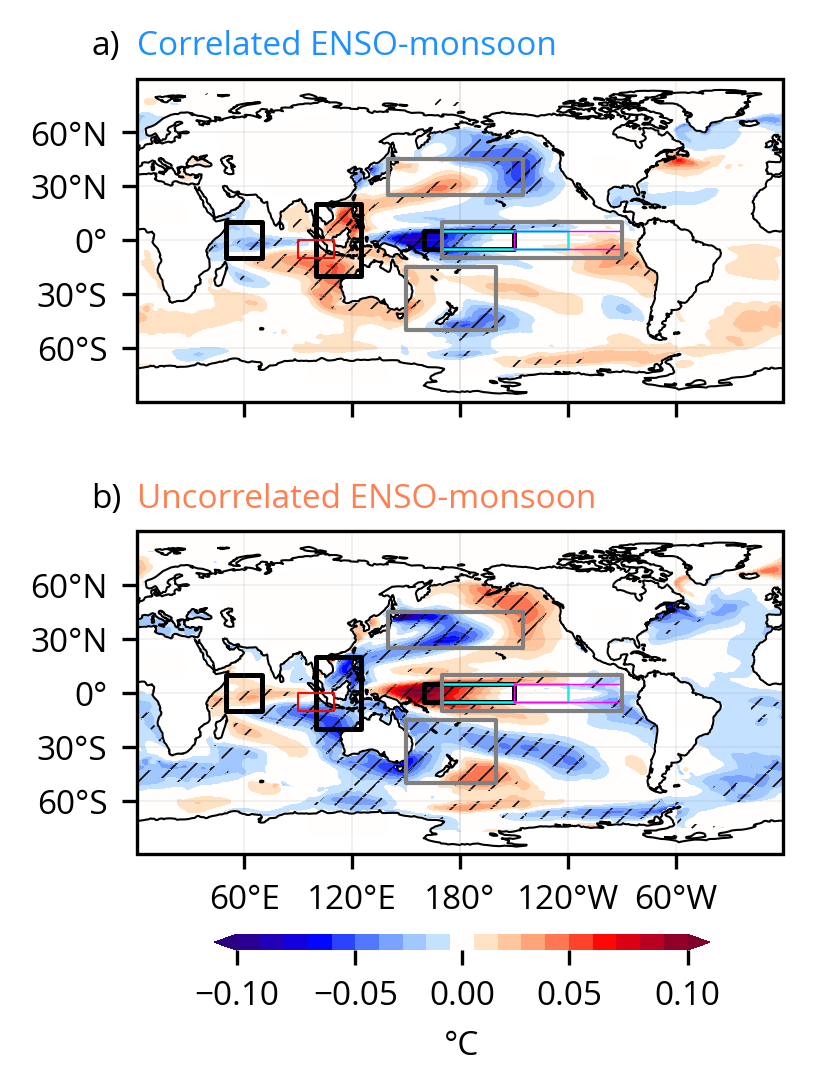

In [ ]:
# Function to convert shapely box to matplotlib Polygon
def add_hatched_box(ax, geom, hatch, crs):
    # Get the exterior coordinates of the shapely box
    coords = list(geom.exterior.coords)
    # Create a Polygon patch from the coordinates
    poly = mpatches.Polygon(coords, closed=True, transform=crs, edgecolor='none', facecolor='none', hatch=hatch, linewidth=0.5)
    # Add the patch to the axis
    ax.add_patch(poly)

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 7
fig_height_cm = 9
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 1, top=0.93, bottom=0.20, right=0.99, hspace=0.4, wspace=0.12)

ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))

levels = [-.10, -0.09, -.08, -0.07, -.06, -0.05, -.04,-0.03, -.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
ticks=[-0.1, -0.05, 0, 0.05, 0.1]

############## Figure 2a ##############
lower_sst_da_difference_da.sel(lon=320, method='nearest')[:] = lower_sst_da_difference_da.sel(lon=321, method='nearest')
im = plots.draw_quartile_anomalies(lower_sst_da_difference_da, fig, ax1, lower_pvals, 
                    vmin=-0.10, vmax=0.10, 
                    levels=levels,
                    ticks=ticks,
                    cmap=cmaps.NCV_blu_red)

for ax in [ax1, ax2]:
    ax.set_yticks([-60, -30, 0, 30, 60], 
                                    crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, -30, 0, 30, 60],fontsize=8)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

############## Figure 2b ##############
upper_sst_difference_da.sel(lon=320, method='nearest')[:] = upper_sst_difference_da.sel(lon=321, method='nearest')
im = plots.draw_quartile_anomalies(upper_sst_difference_da, fig, ax2, upper_pvals, 
                    vmin=-0.10, vmax=0.10, 
                    levels=levels,
                    ticks=ticks,
                    cmap=cmaps.NCV_blu_red)


for ax in [ax1]:
    ax.set_xticks([60, 120, 180, 240, 300],
                                    crs=ccrs.PlateCarree())
    ax.set_xticklabels([],fontsize=8)

for ax in [ax2]:
    ax.set_xticks([60, 120, 180, 240, 300],
                                    crs=ccrs.PlateCarree())
    ax.set_xticklabels([60, 120, 180, 240, 300],fontsize=8)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)

# Set subplot labels
titles1 = ["a)", "b)"]
titles2 = ["Correlated ENSO-monsoon", "Uncorrelated ENSO-monsoon"]
colors = ['dodgerblue', 'coral']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

for ax in [ax1, ax2]:
    ax.set_global()

    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    geom = geometry.box(minx=50, maxx=70, miny=-10, maxy=10)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=1.2)

    # Central: 100–125°E, -20°S–20°N)
    geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=1.2)

    # Nino4
    geom = geometry.box(minx=160, maxx=210, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=1.2)

    # IOD East
    geom = geometry.box(minx=90, maxx=110, miny=-10, maxy=0)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=0.5)

    # Nino3.4
    geom = geometry.box(minx=-190, maxx=-120, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='cyan', facecolor='none', linewidth=0.6)

    # Nino3
    geom = geometry.box(minx=-150, maxx=-90, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='magenta', facecolor='none', linewidth=0.35)

    # Equatorial Pacific: (170°E-90°W, 10°S-10°N)
    geom = geometry.box(minx=-190, maxx=-90, miny=-10, maxy=10)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=1)

    # North Pacific: 140°E-145°W, 25-45°N
    geom = geometry.box(minx=-220, maxx=-145, miny=25, maxy=45)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=1)

    # South Pacific: 50°S to 15°S, 150°E to 160°W (or -160° in longitude)
    geom = geometry.box(minx=-210, maxx=-160, miny=-50, maxy=-15)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=1)

cbar_ax = fig.add_axes([0.26, 0.11, 0.6, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-.1, -.05, 0, .05, .1], label="°C", orientation="horizontal", shrink=0.50)
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)

plt.savefig("FigS5.png")
plt.savefig("FigS5.pdf")